# Behavioral-epidemic models for COVID-19 

This notebook shows how to run the behavioral-epidemic models for COVID-19.

First, we import the necessary libraries:

In [12]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from models.mobility_model_age import SEIR_mobility, compute_contact_reductions
from models.compartment_model_age_deaths import SEIR_compartment
from models.function_model_age_deaths import SEIR_function

from models.constants import *

Then, we import the data for Madrid that we will use to run the models:

In [2]:
basin = 'madrid'

epi_data = pd.read_csv(f'./data/{basin}/epi-data/epi_data.csv')
pop_data = pd.read_csv(f'./data/{basin}/population-data/pop_data_Nk.csv')
mob_data = pd.read_csv(f'./data/{basin}/google-mobility-report/google_mobility_data.csv')
hemisphere = pd.read_csv(f"./data/{basin}/hemisphere/hemisphere.csv").hemisphere_code[0]
C = np.load(f"./data/{basin}/contact_matrix/contact_matrix.npz")["arr_0"] 
Nk = pd.read_csv(f"./data/{basin}/population-data/pop_data_Nk.csv").values[0]

# simulation dates 
dates = pd.to_datetime(mob_data.date.values)

## Data-Driven Behavioral (DDB) Model

In the following, we run the Data-Driven Behavioral (DDB) Model. In the DDB model, the force of infection is modulated by a contact reduction factor that is computed as a function of the mobility data. 

First, we compute the contact reduction factor as a function of the mobility data:

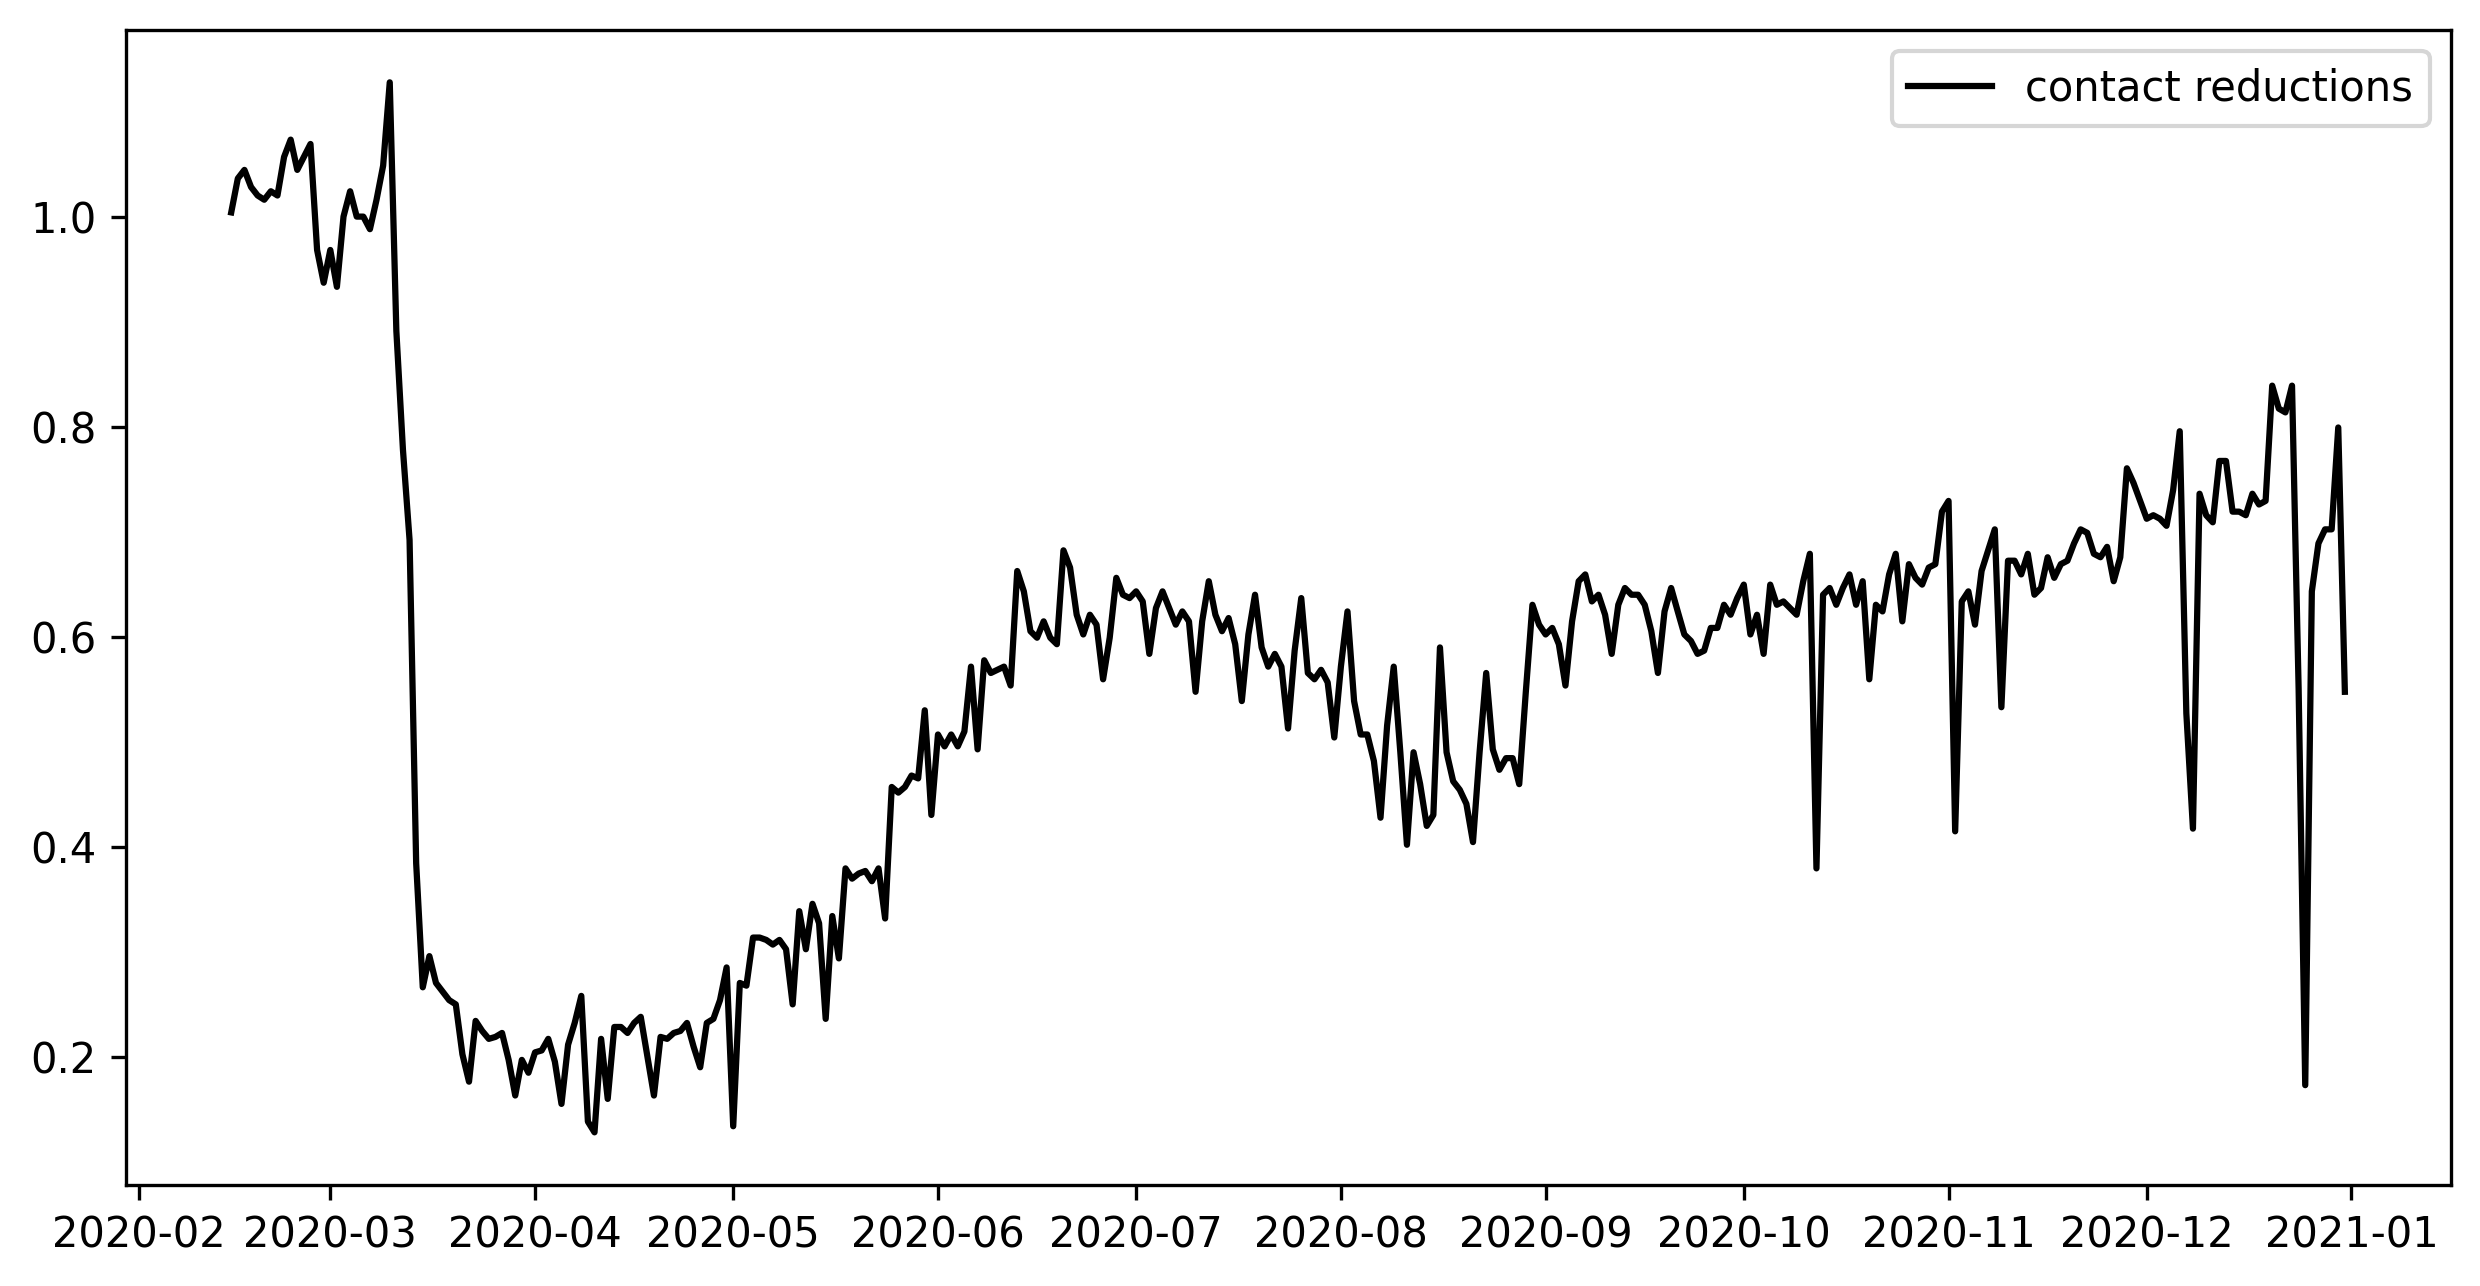

In [3]:
# compute contact reductions 
contact_reductions = compute_contact_reductions(mob_data=mob_data, 
                                                columns=['retail_and_recreation_percent_change_from_baseline',
                                                        'grocery_and_pharmacy_percent_change_from_baseline',
                                                        'transit_stations_percent_change_from_baseline',
                                                        'workplaces_percent_change_from_baseline',
                                                        'residential_percent_change_from_baseline'])

fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
contact_reductions["date"] = pd.to_datetime(contact_reductions["date"])
plt.plot(contact_reductions.date, contact_reductions.r.values, label="contact reductions", color='k')
plt.legend()
plt.show()

Next, we run the DDB model:

Text(0, 0.5, 'Daily reported deaths (simulated)')

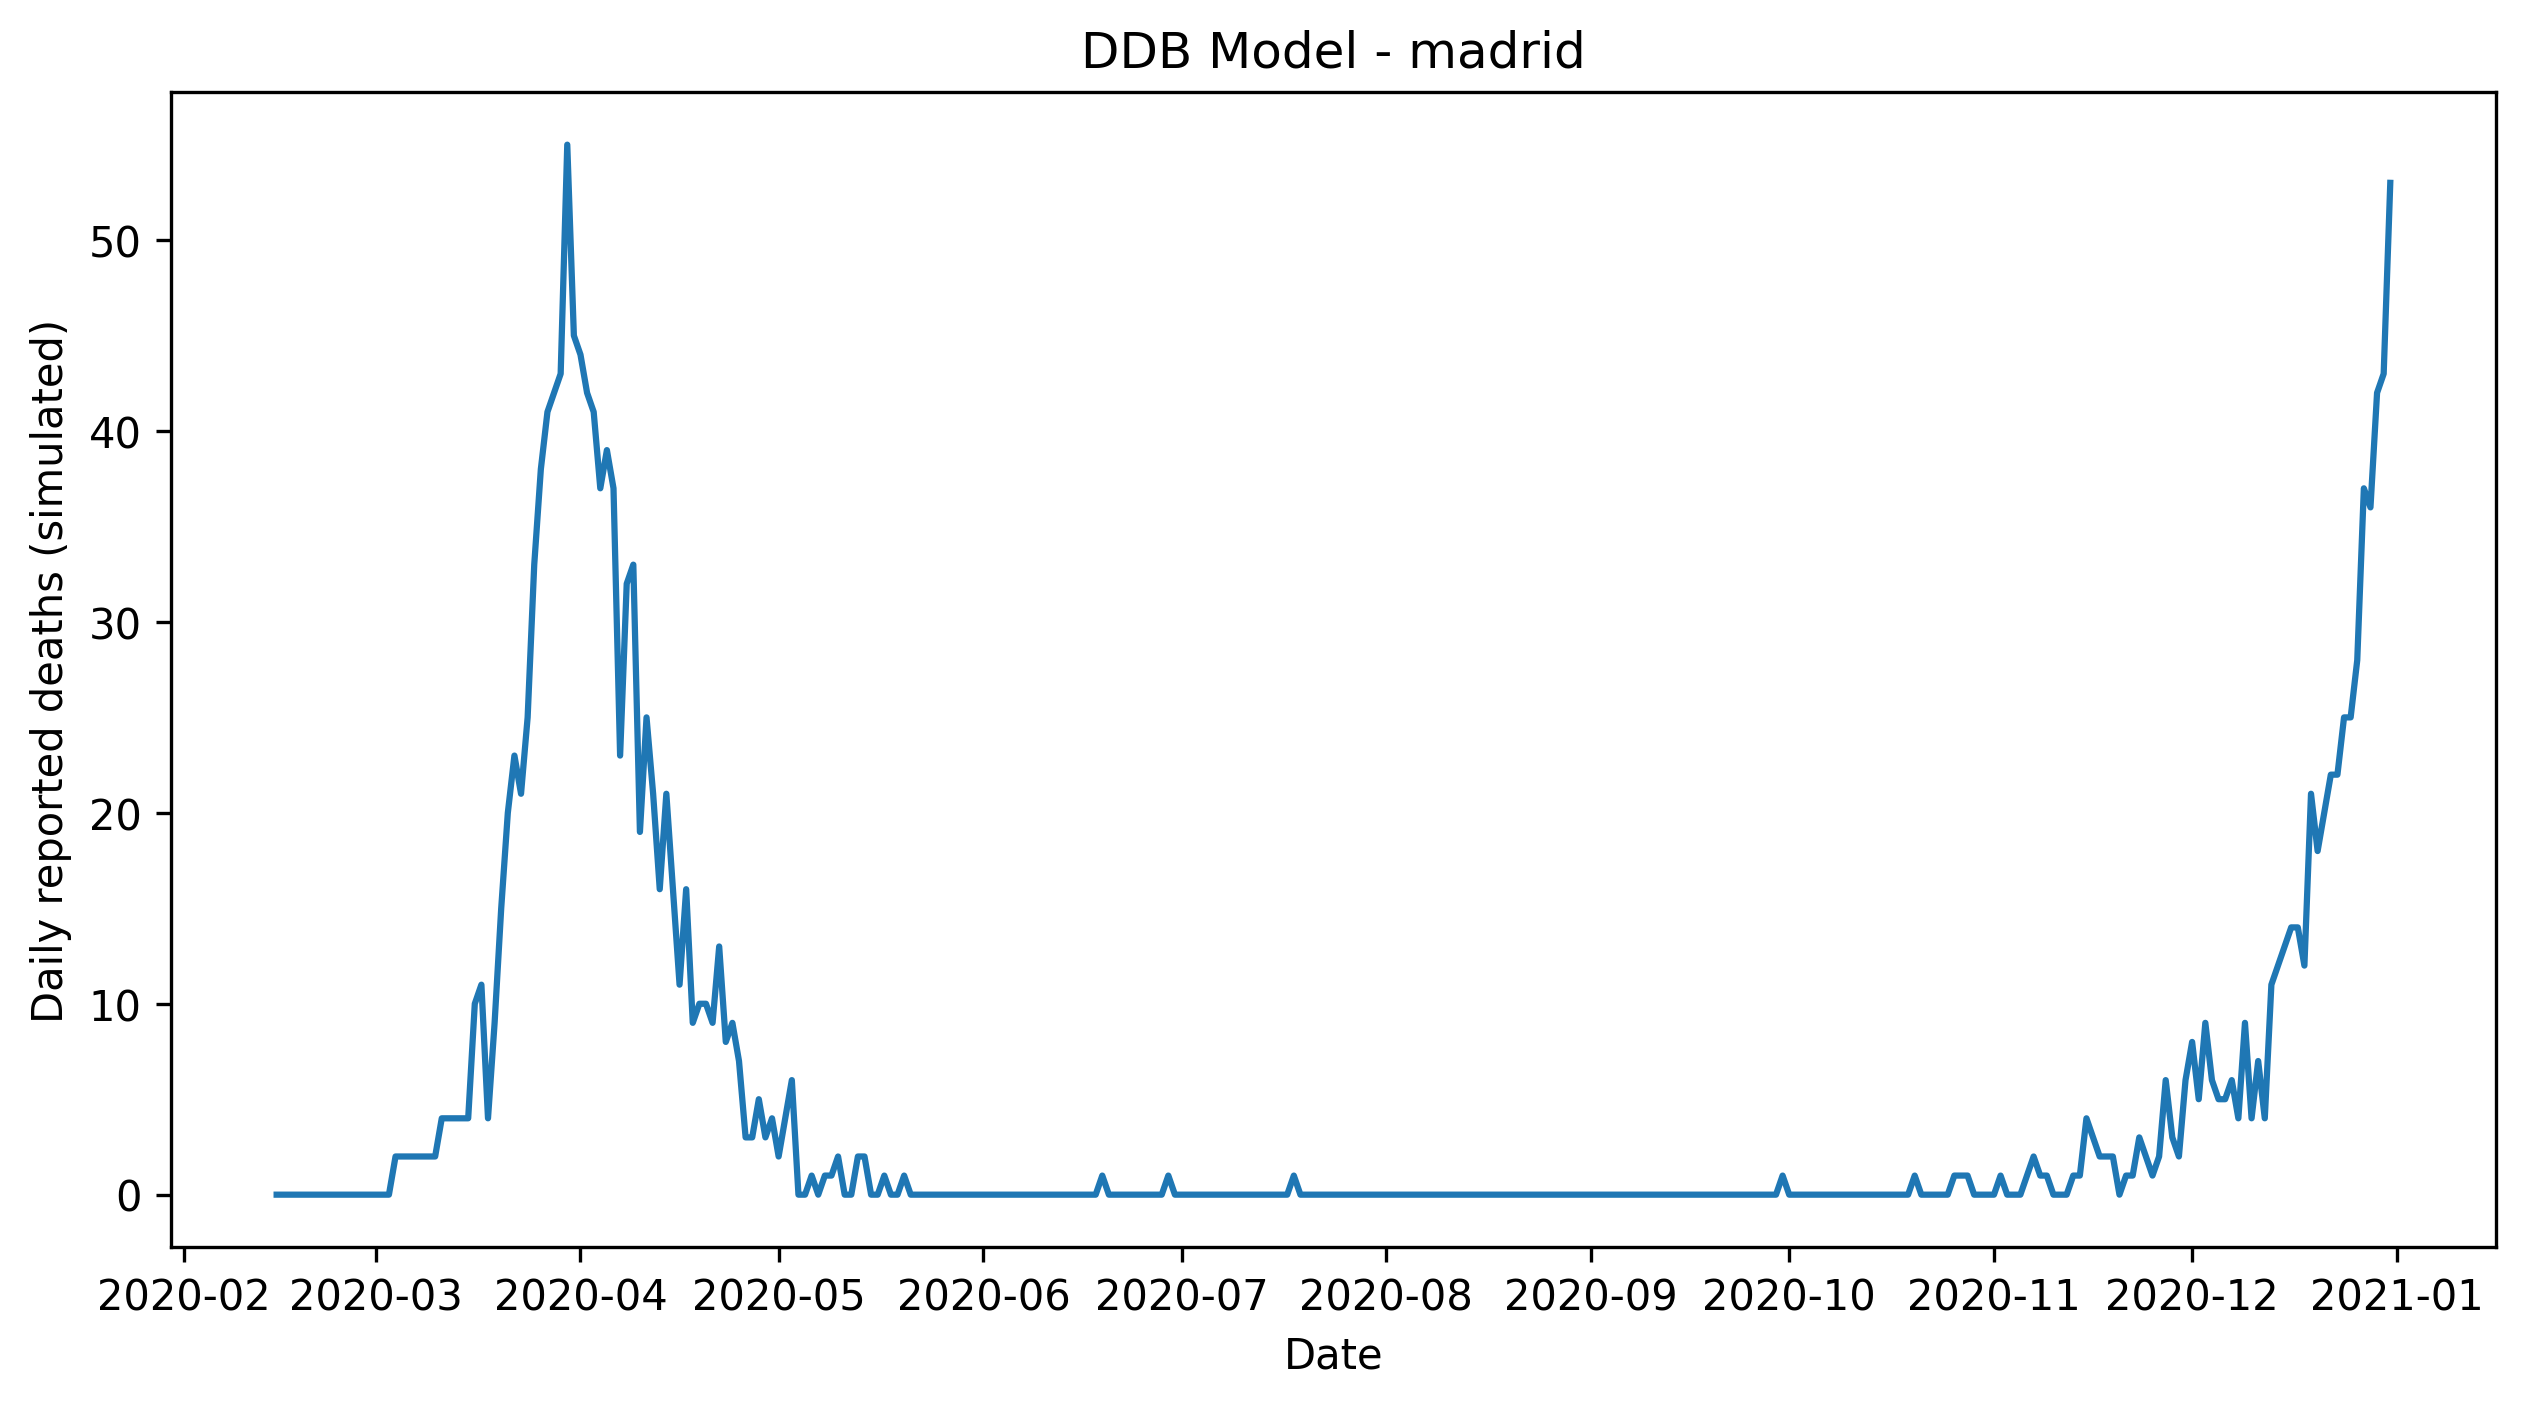

In [4]:
results = SEIR_mobility(inf_t0=1000, 
                  rec_t0=0,
                  Nk=Nk, 
                  r=contact_reductions.r.values,
                  T=len(mob_data), 
                  R0=2.5, 
                  eps=eps, 
                  mu=mu,
                  ifr=IFR_10age,
                  Delta=14, 
                  C=C, 
                  detection_rate=0.7, 
                  dates=dates, 
                  hemisphere=hemisphere, 
                  seasonality_min=0.75)

# plot results  (observed deaths)
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
ax.plot(dates, results["deaths"])
ax.set_title("DDB Model - {}".format(basin))
ax.set_xlabel("Date")
ax.set_ylabel("Daily reported deaths (simulated)")

## Compartmental Behavioral Feedback (CBF) Model

In the following, we run the Compartmental Behavioral Feedback (CBF) Model. In the CBF model, a new compartment ($S^B$) of individuals that adopt behavioral prevented measures is introduced. As a result of those measures, these individuals get infected at a lower rate, according to a parameter $r<1$.

In [5]:
# common parameters to all simulations
params_cbf = dict(inf_t0=1000, 
            rec_t0=0,
            Nk=Nk, 
            T=len(mob_data), 
            R0=2.5, 
            eps=eps, 
            mu=mu, 
            beta_B=0.5, 
            mu_B=0.01, 
            r=0.5, 
            ifr=IFR_10age,
            Delta=14, 
            C=C, 
            detection_rate=0.7,
            dates=dates, 
            hemisphere=hemisphere, 
            seasonality_min=0.75,
            gamma=0, 
            behavioral_mechanism="global")

First, we run the CBF model with a global behavioral mechanism but multiple values of the behavioral parameter $\gamma$. In more detail, the parameter passed to the `SEIR_compartment` function is the exponent of the behavioral parameter, i.e. $10^{\gamma}$. For lower values of $\gamma$, the behavioral effect is stronger:

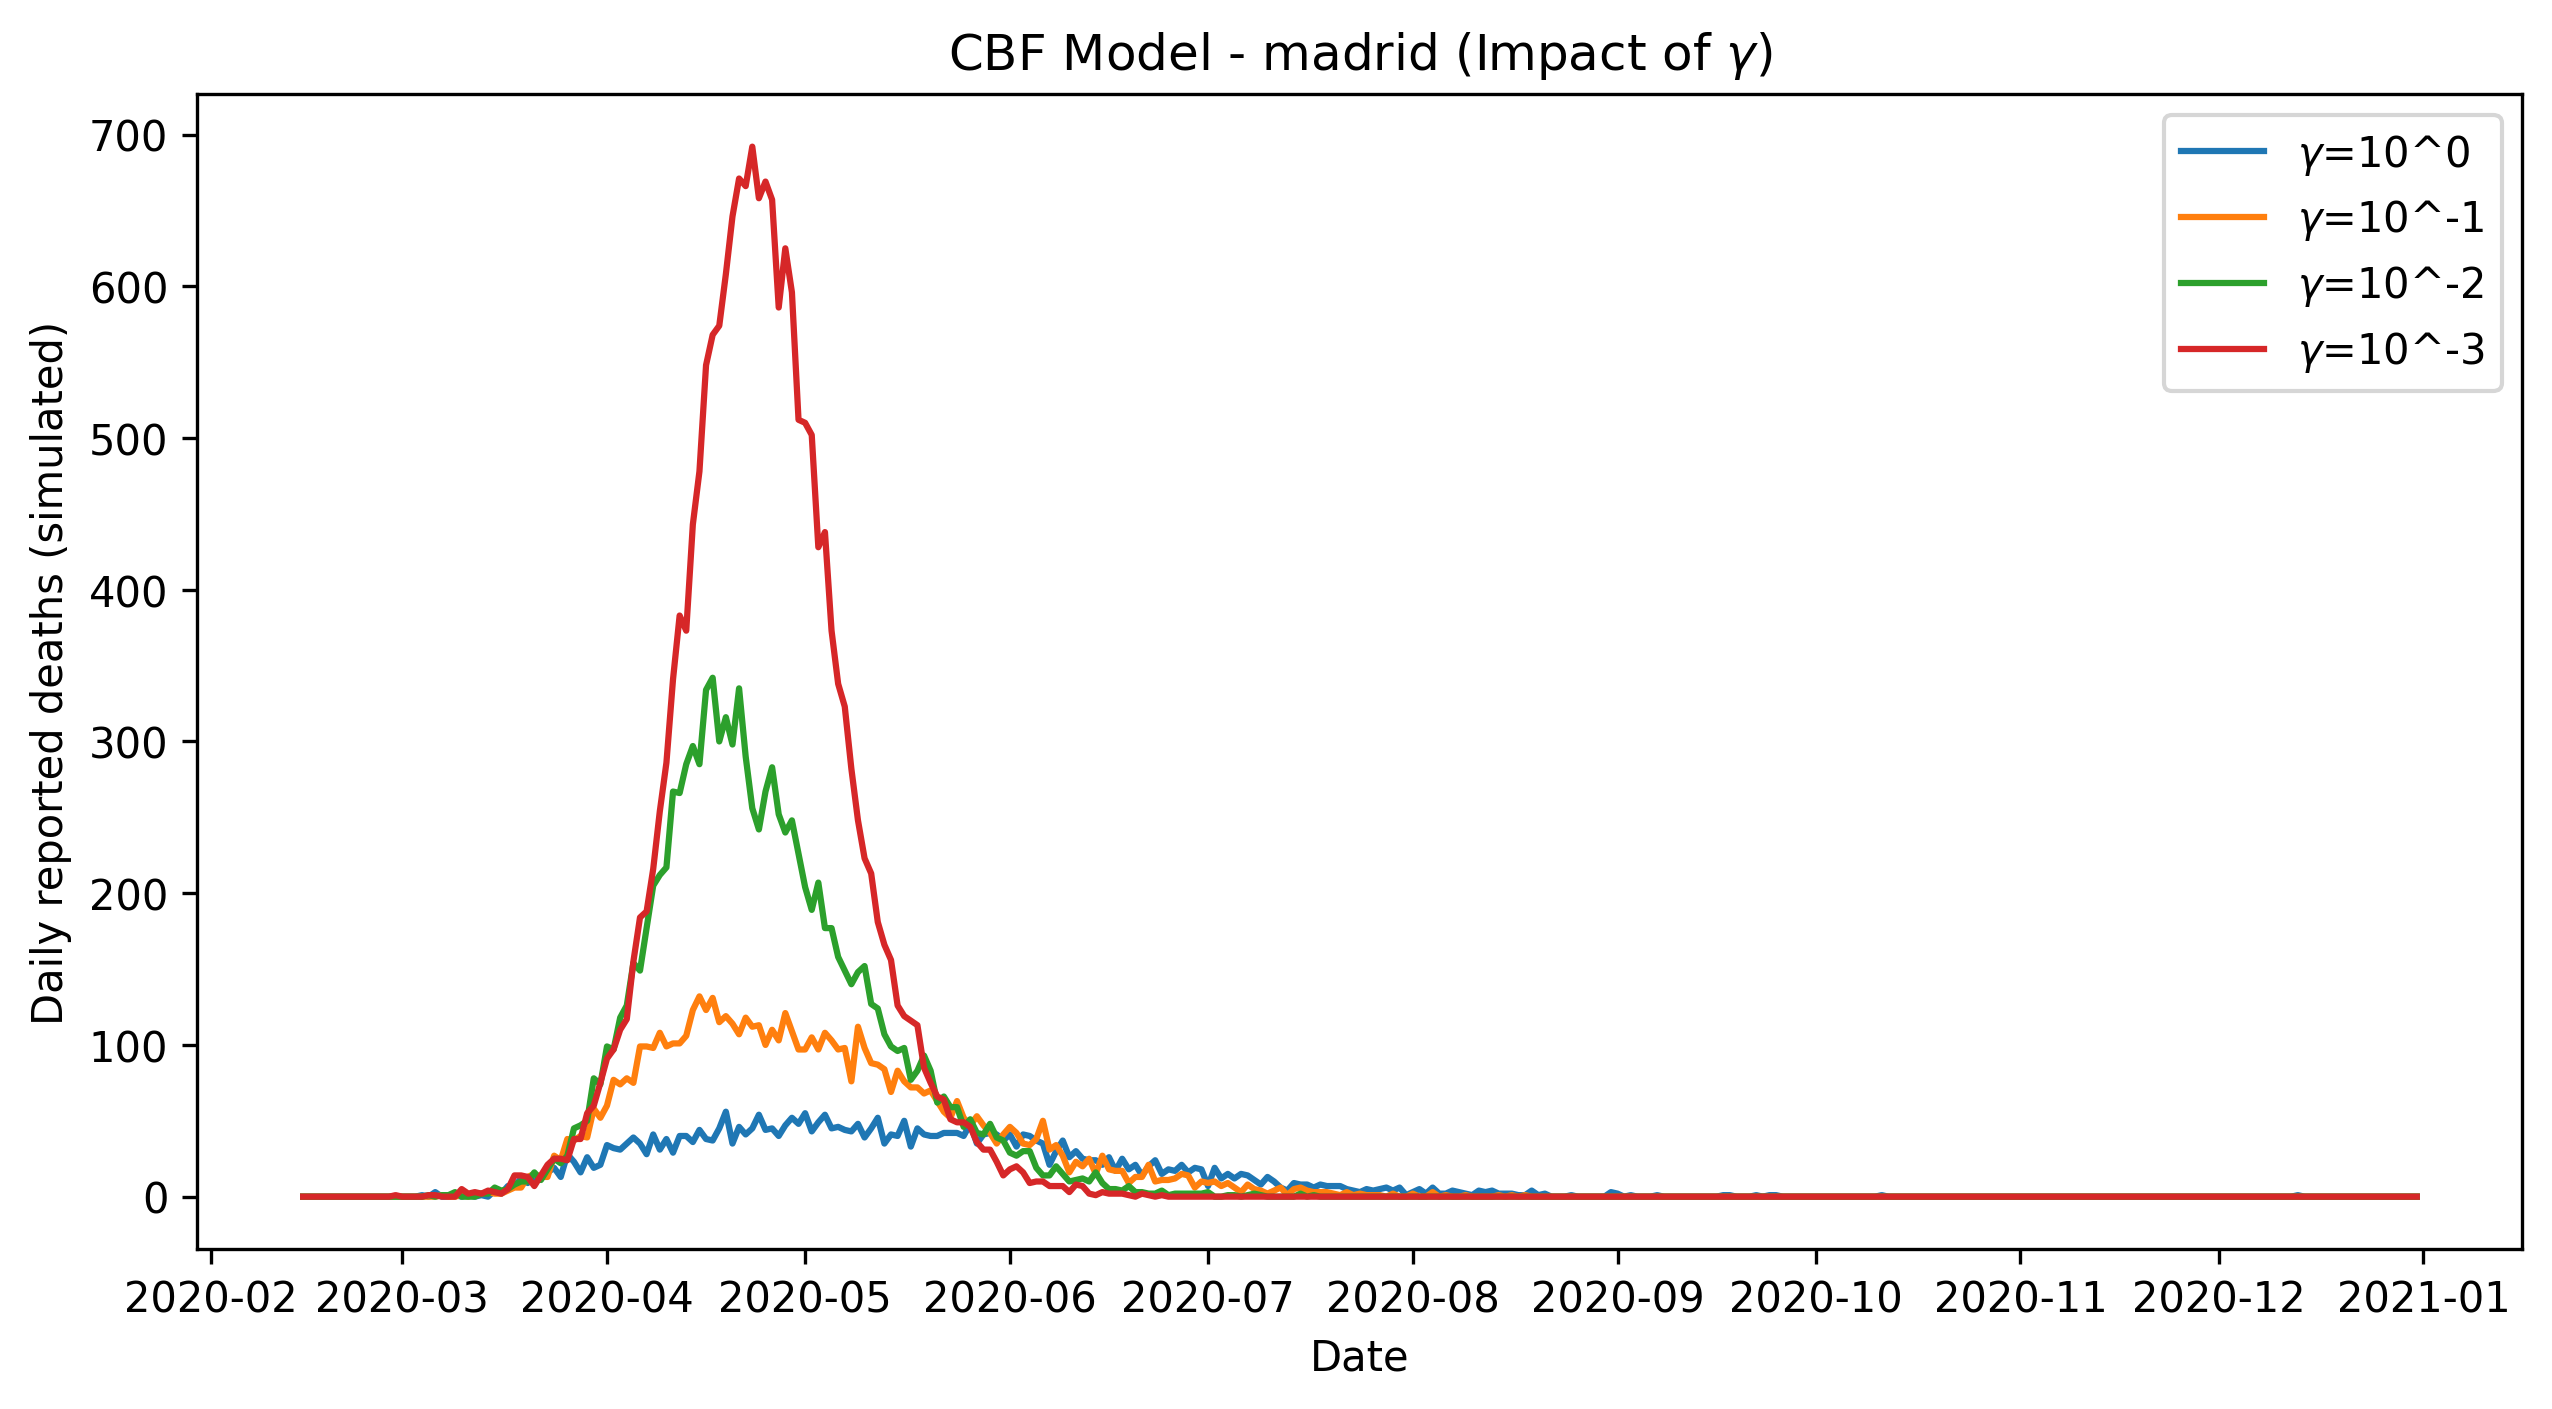

In [6]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

for gamma in [0, -1, -2, -3]:
    params_cbf["gamma"] = gamma
    results = SEIR_compartment(**params_cbf)
    ax.plot(dates, results["deaths"], label=f"$\\gamma$=10^{gamma}")

ax.set_title("CBF Model - {} (Impact of $\\gamma$)".format(basin))
ax.set_xlabel("Date")
ax.set_ylabel("Daily reported deaths (simulated)")
ax.legend()


Next, we run the CBF model with a local and global behavioral mechanism:

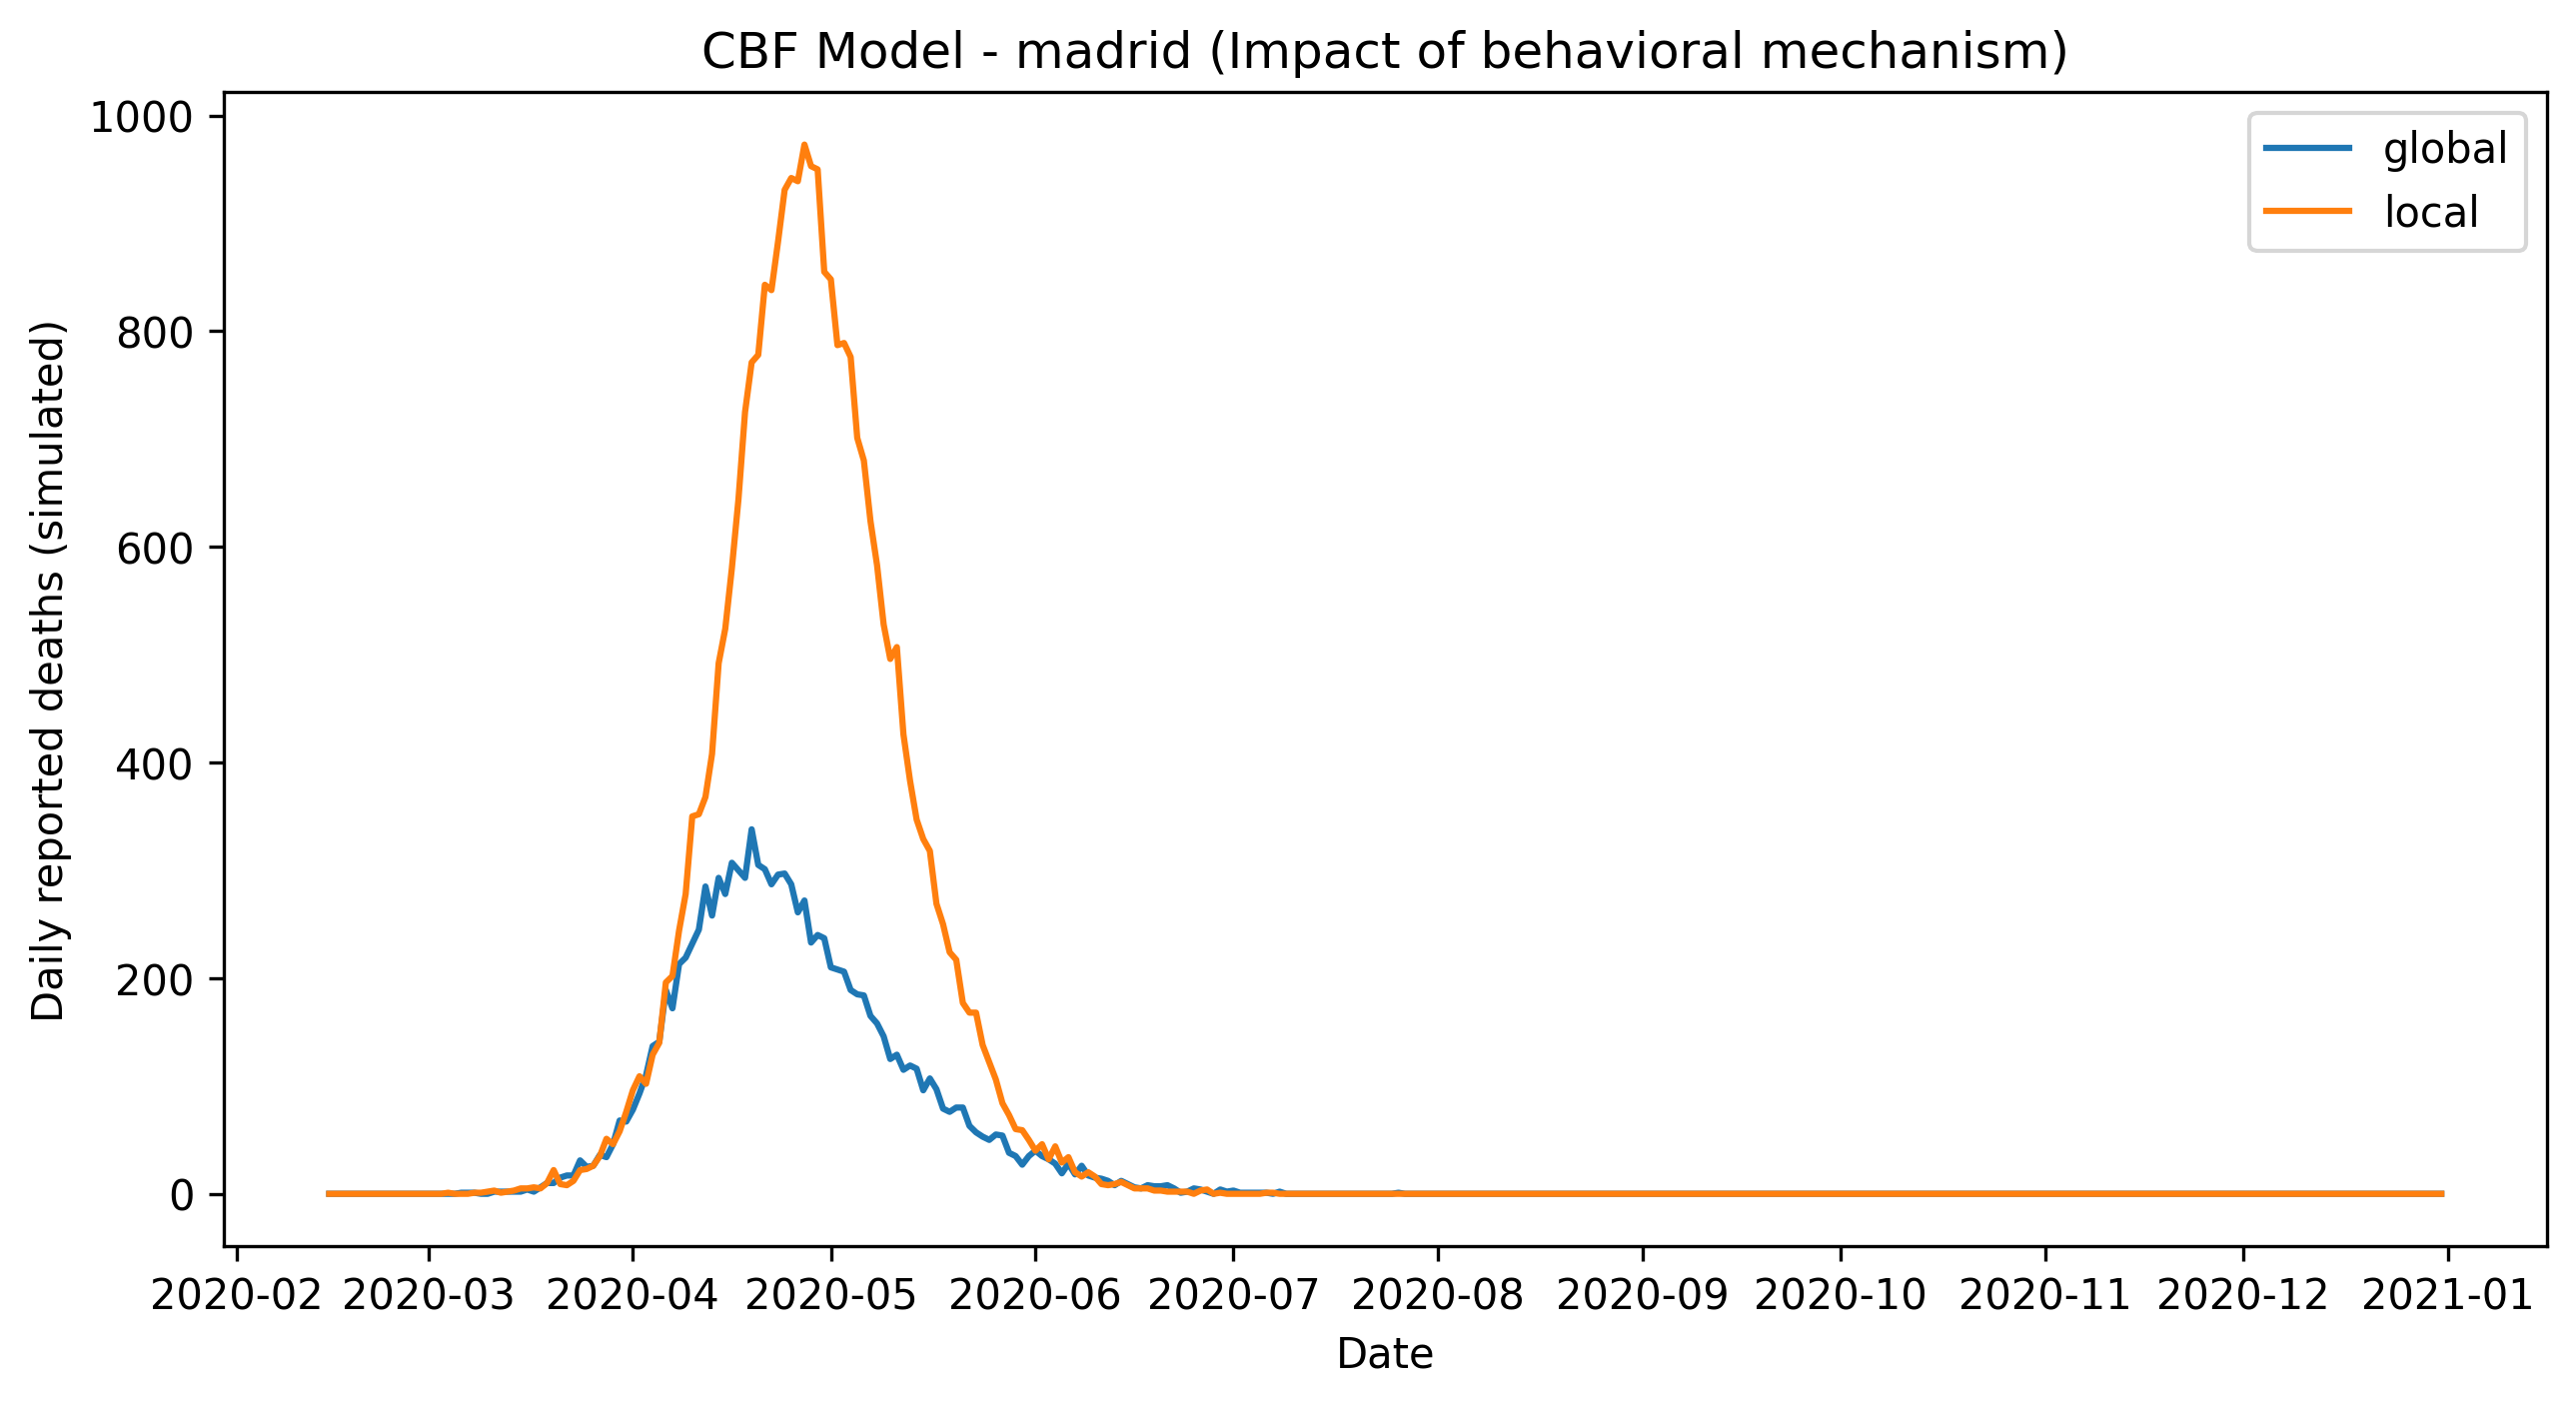

In [7]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

params_cbf["gamma"] = -2
for mechanism in ["global", "local"]:
    params_cbf["behavioral_mechanism"] = mechanism
    results = SEIR_compartment(**params_cbf)
    
    ax.plot(dates, results["deaths"], label=mechanism)

ax.set_title("CBF Model - {} (Impact of behavioral mechanism)".format(basin))
ax.set_xlabel("Date")
ax.set_ylabel("Daily reported deaths (simulated)")
ax.legend()


Next, we run the CBF model with a local behavioral mechanism but multiple values of the behavioral parameter $r$. For lower values of $r$, the protection effect of the behavioral measures is stronger:

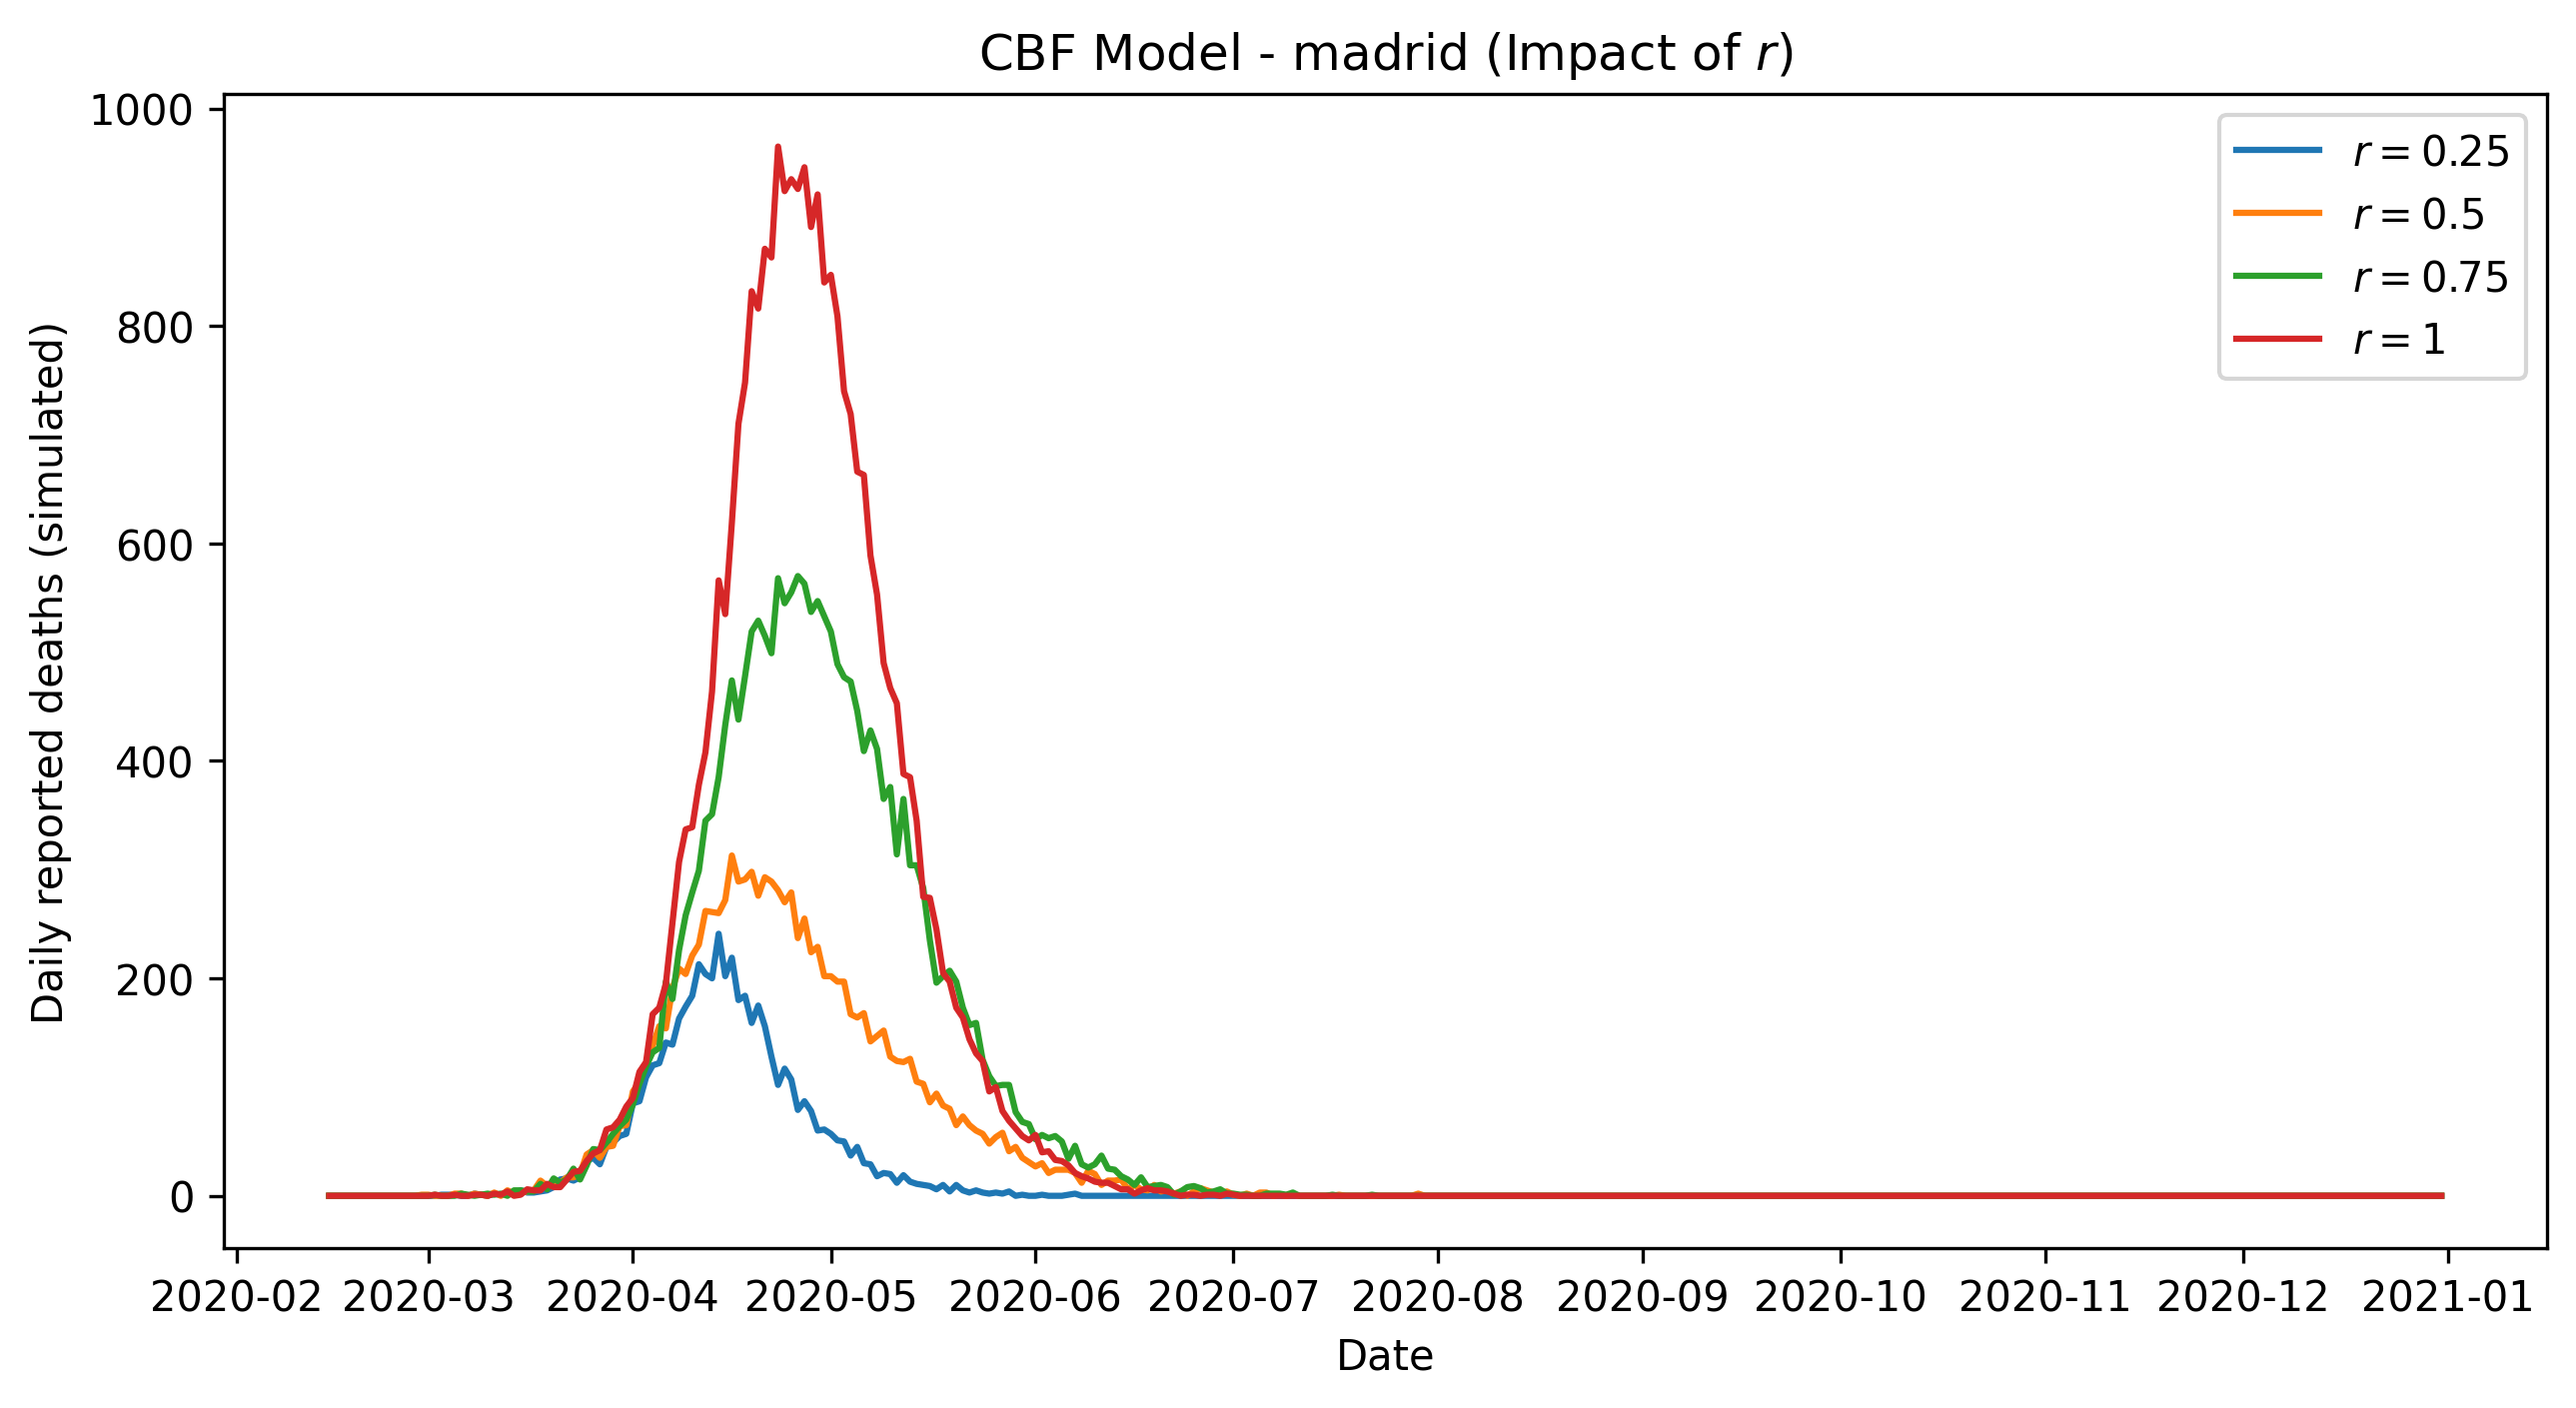

In [8]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

params_cbf["behavioral_mechanism"] = "global"
for r in [0.25, 0.5, 0.75, 1]:
    params_cbf["r"] = r
    results = SEIR_compartment(**params_cbf)
    ax.plot(dates, results["deaths"], label=f"$r={r}$")

ax.set_title("CBF Model - {} (Impact of $r$)".format(basin))
ax.set_xlabel("Date")
ax.set_ylabel("Daily reported deaths (simulated)")
ax.legend()


## Effective Force of Infection Behavioral Feedback (EFB) Model

Finally, we run the Effective Force of Infection Behavioral Feedback (EFB) Model. In the EFB model, the force of infection is non-linear and saturates as the number of reported deaths increases.

In [9]:
# common parameters to all simulations
params_efb = dict(inf_t0=1000, 
            rec_t0=0,
            Nk=Nk, 
            T=len(mob_data), 
            R0=2.5, 
            eps=eps, 
            mu=mu, 
            dc=-2, 
            Dc=-3, 
            ifr=IFR_10age,
            Delta=14, 
            C=C, 
            detection_rate=0.7,
            dates=dates, 
            hemisphere=hemisphere, 
            seasonality_min=0.75,
            long_term=False)

We run the EFB model with different values of $d_c$, which controls the speed of the saturation of the force of infection for recent deaths (short-term memory). Again, the parameters that are passed to the `SEIR_function` function is the logarithm of $d_c$ and $D_c$, i.e. the parameters are $10^{d_c}$ and $10^{D_c}$.

Lower values of $d_c$ lead to a faster saturation of the force of infection for recent deaths, i.e. a faster decay of the force of infection.

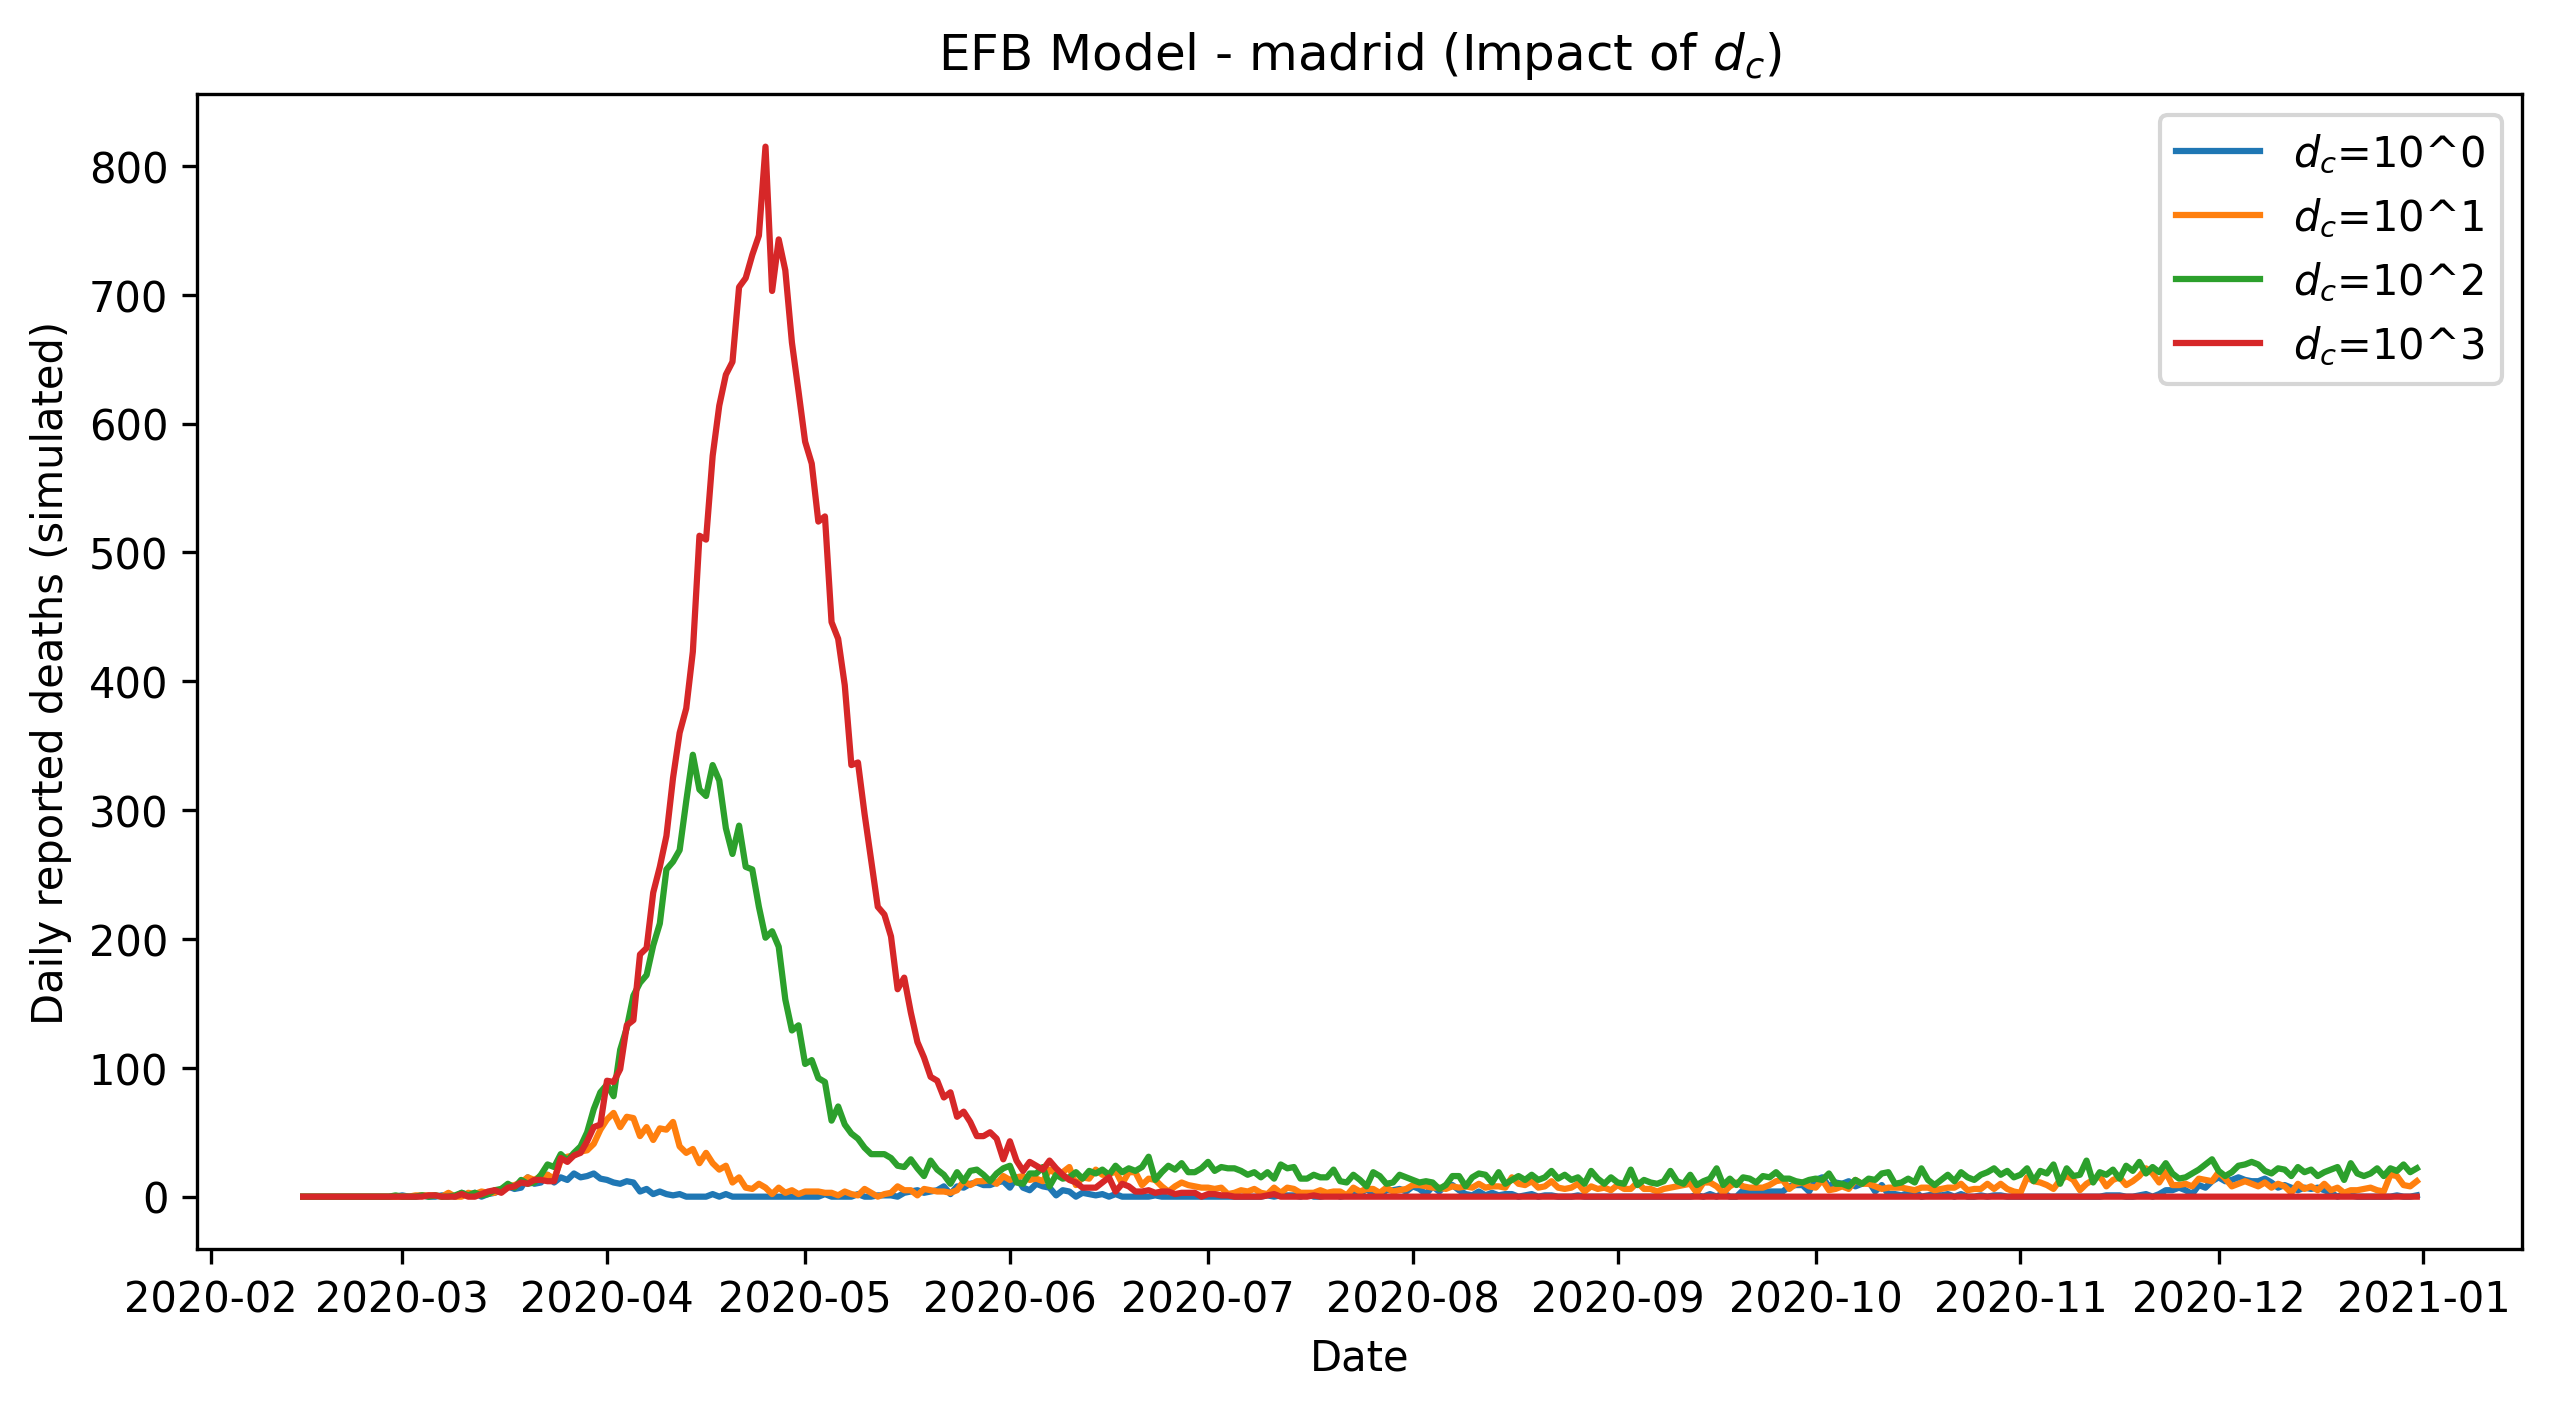

In [10]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

for dc in [0, 1, 2, 3]:
    params_efb["dc"] = dc
    results = SEIR_function(**params_efb)
    ax.plot(dates, results["deaths"], label=f"$d_c$=10^{dc}")

ax.set_title("EFB Model - {} (Impact of $d_c$)".format(basin))
ax.set_xlabel("Date")
ax.set_ylabel("Daily reported deaths (simulated)")
ax.legend()


Next, we run the EFB model with and without long-term memory effect. The long-term memory effect is controlled by the parameter $D_c$, which controls the speed of the decay of the force of infection for past deaths (long-term memory).

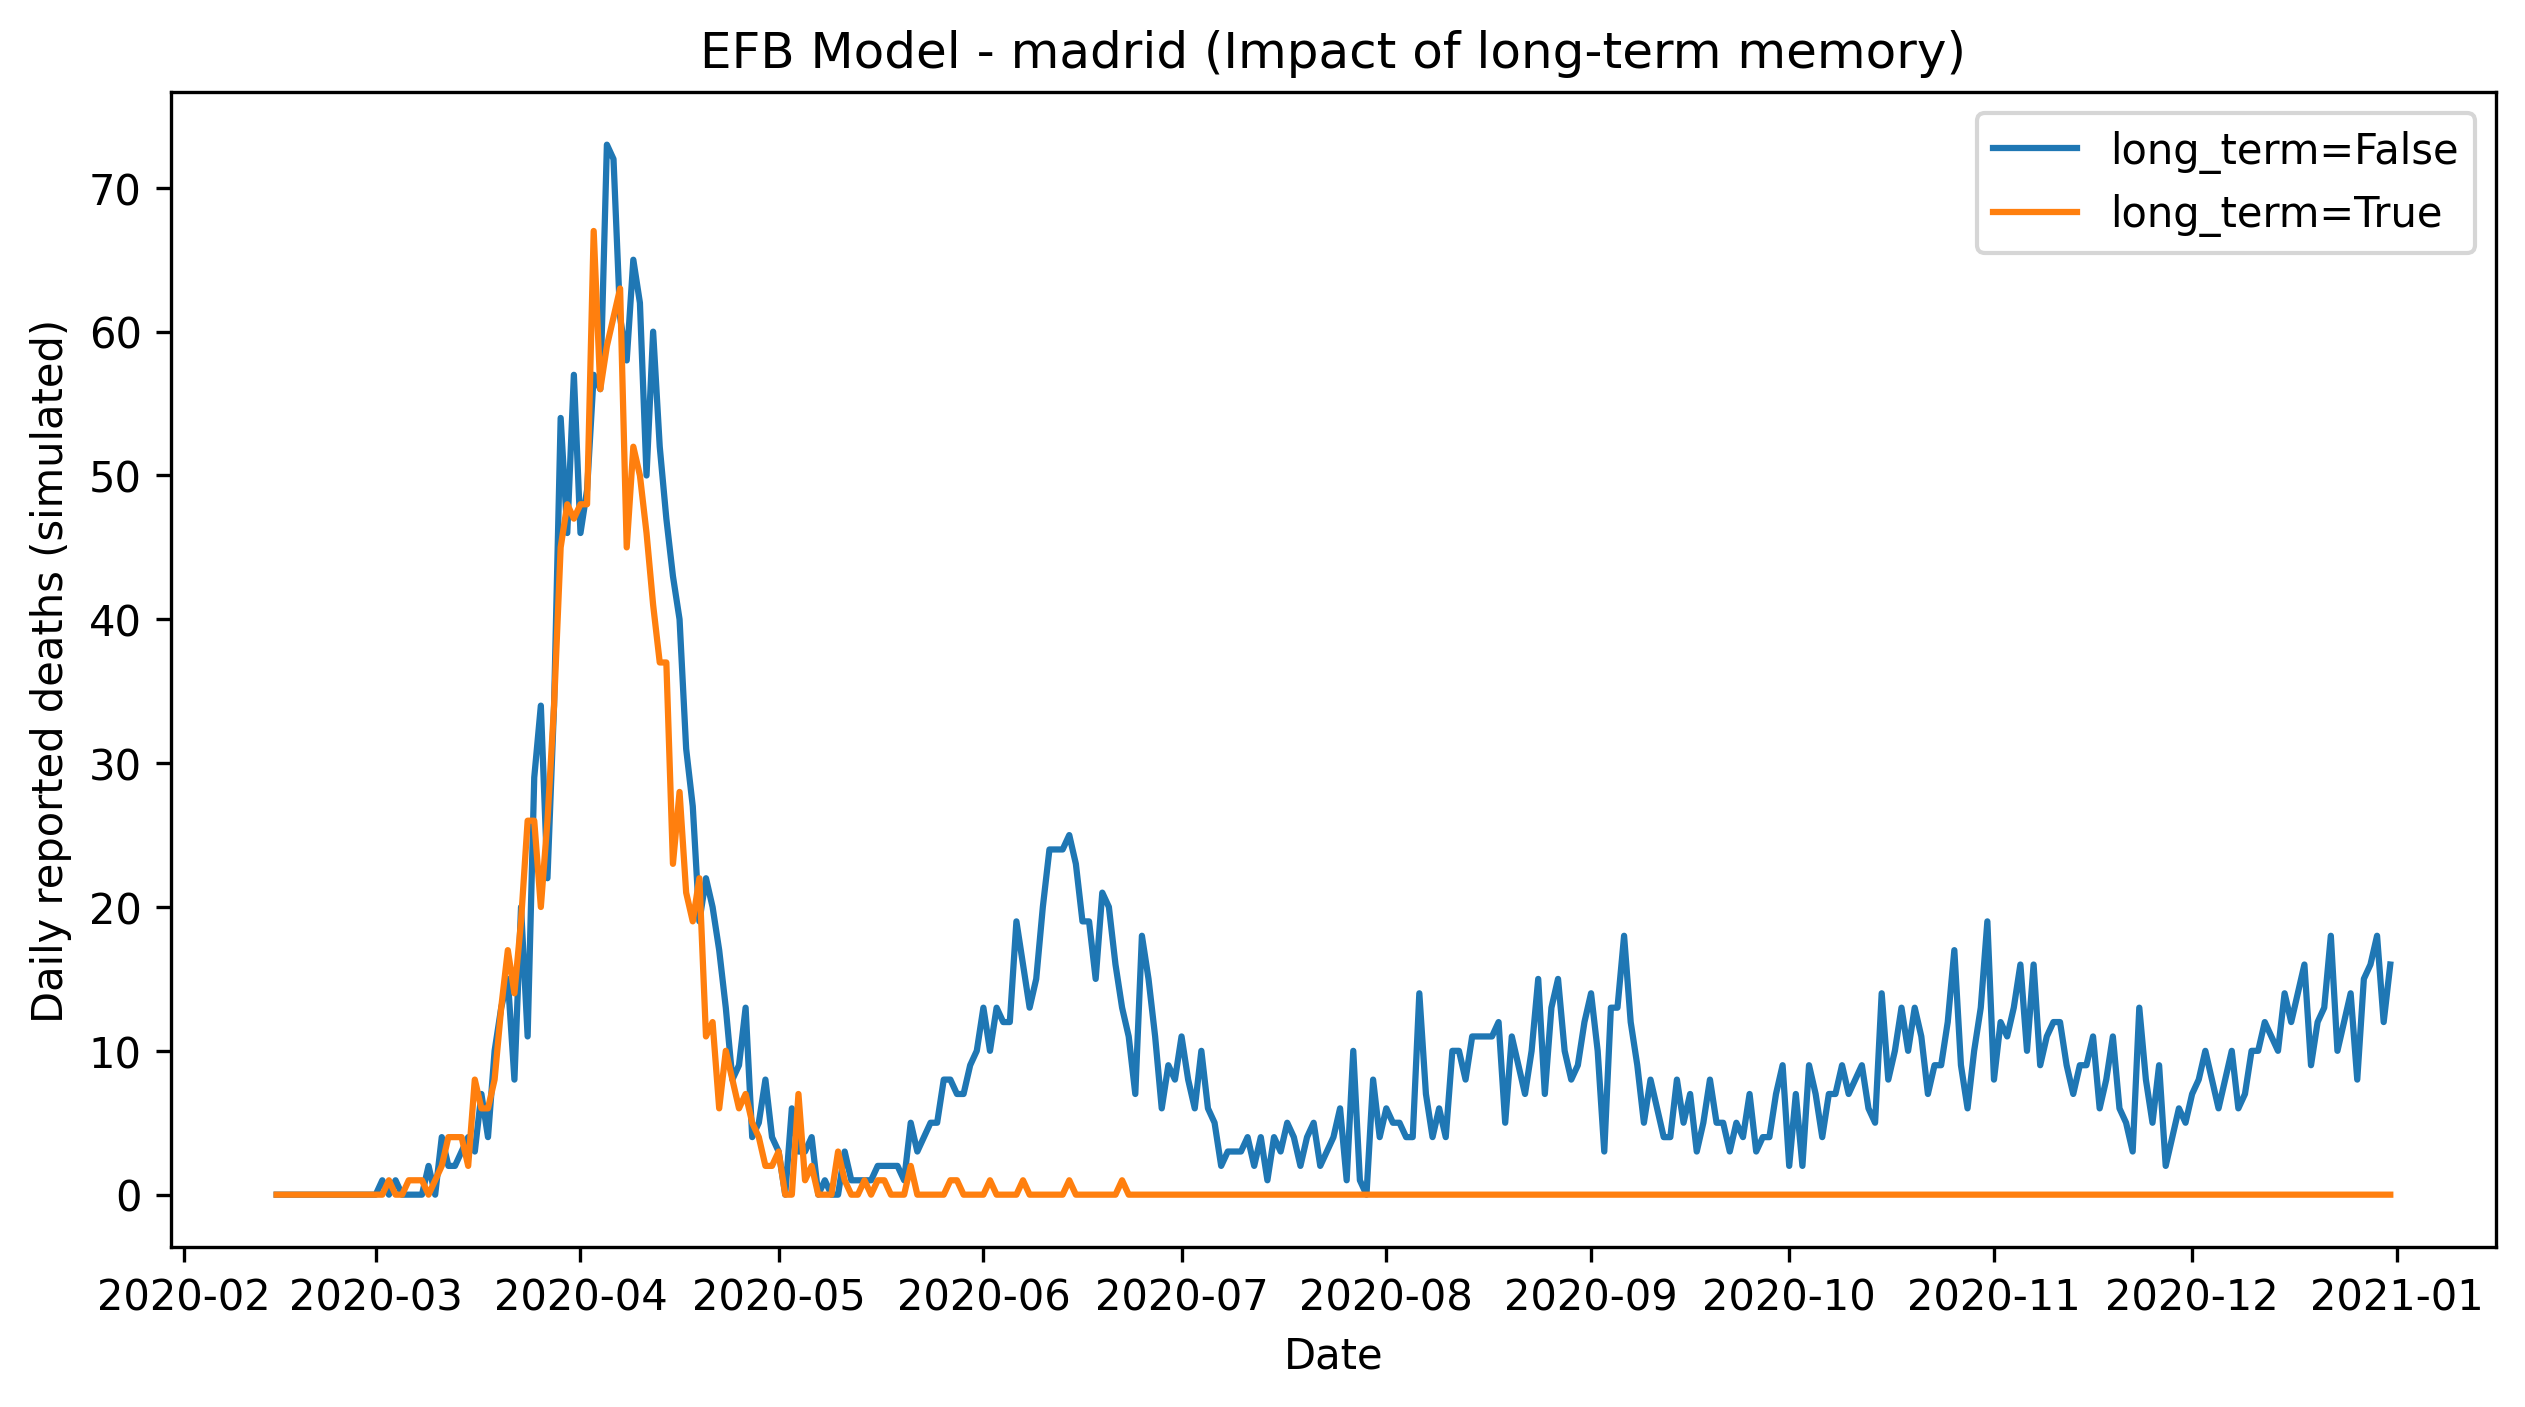

In [11]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

params_efb["dc"] = 1
params_efb["Dc"] = 3

for long_term in [False, True]:
    params_efb["long_term"] = long_term
    results = SEIR_function(**params_efb)
    ax.plot(dates, results["deaths"], label=f"long_term={long_term}")

ax.set_title("EFB Model - {} (Impact of long-term memory)".format(basin))
ax.set_xlabel("Date")
ax.set_ylabel("Daily reported deaths (simulated)")
ax.legend()
